In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon April 29 13:25:11 2020

@author: rfuchs
"""

import os 

%matplotlib inline
import pandas as pd
from copy import deepcopy
from gower import gower_matrix
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder 

from MIAMI import MIAMI
from init_params import dim_reduce_init
from data_preprocessing import compute_nj

from shapely.geometry import Polygon as polygon

import autograd.numpy as np

from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import pdist, squareform


In [2]:
res_folder = 'MIAMI/Results/Adult/'

if not os.path.exists(res_folder):
    os.makedirs(res_folder)
#===========================================#
# Model Hyper-parameters
#===========================================#

n_clusters = 4
r = np.array([2, 1])
k = [4]

seed = 1
init_seed = 2
    
# !!! Changed eps
eps = 1E-02
it = 4
maxstep = 100
        

var_distrib = np.array(['continuous', 'categorical', 'continuous',\
                        'ordinal', 'categorical', 'categorical', 'categorical',\
                        'categorical', 'bernoulli', 'ordinal', 'ordinal',\
                        'continuous', 'categorical', 'bernoulli']) 

# Plotting utilities
varnames = np.array(['age', 'workclass', 'fnlwgt',\
            'education.num', 'marital.status', 'occupation', 'relationship',\
            'race', 'sex', 'capital.gain', 'capital.loss',\
            'hours.per.week', 'native.country', 'income'])

    
dtypes_dict = {'continuous': float, 'categorical': str, 'ordinal': int,\
              'bernoulli': int, 'binomial': int}
    
    

#===========================================#
# Importing data
#===========================================#

inf_nb = 1E12
nb_pobs = 200


# acceptance_rate =
le_dict = {}

train_filepath = res_folder + 'adult.csv'


train = pd.read_csv(train_filepath, sep = ',')
train = train.infer_objects()



# Delete the missing values 
train = train.loc[~(train == '?').any(axis=1)]
# print(train)
NUMBER_OBSERVATIONS = 1000
train = train.iloc[:NUMBER_OBSERVATIONS, :]
numobs = len(train)
print("Running with", numobs, "observations!!!!")
# !!! Hack to remove
del(train['educational-num'])
p = train.shape[1]

new_names_dict = dict(zip(train.columns, varnames))

train = train.rename(columns=new_names_dict)
train = train.reset_index(drop=True)

train_original = train.copy()


# Find the indices of the continuous features
continuous_indices = np.where(var_distrib == 'continuous')[0]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the continuous features
train.iloc[:, continuous_indices] = scaler.fit_transform(train.iloc[:, continuous_indices])


Running with 1000 observations!!!!


In [3]:
print(train.dtypes)

age               float64
workclass          object
fnlwgt            float64
education.num      object
marital.status     object
occupation         object
relationship       object
race               object
sex                object
capital.gain        int64
capital.loss        int64
hours.per.week    float64
native.country     object
income             object
dtype: object


In [4]:
train_original

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,25,Private,226802,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,198693,10th,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,81,Private,184615,7th-8th,Widowed,Machine-op-inspct,Unmarried,White,Female,1264,0,40,United-States,<=50K
996,28,Private,173858,HS-grad,Never-married,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,35,China,<=50K
997,28,Private,132326,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
998,43,Private,315037,Bachelors,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,45,United-States,>50K


In [5]:
# print(train["native.country"].value_counts())

In [6]:
#***************************************************************************
# Invert the order of the columns so that age is no more the first bernoulli
#***************************************************************************
'''
train[['age', 'workclass', 'fnlwgt', 'education.num', 'marital.status',
        'occupation', 'relationship', 'race', 'capital.gain',
        'capital.loss', 'hours.per.week', 'native.country', 'income', 'sex']]


var_distrib = np.array(['continuous', 'categorical', 'continuous',\
            'ordinal', 'categorical', 'categorical', 'categorical',\
            'categorical', 'ordinal', 'ordinal',\
            'continuous', 'categorical', 'bernoulli', 'bernoulli']) 
'''
                    
p_new = len(var_distrib)
cat_features = np.logical_or(var_distrib == 'categorical', var_distrib == 'ordinal')


#*****************************************************************
# Formating the data
#*****************************************************************
                
# Encode categorical datas
for col_idx, colname in enumerate(train.columns):
    if var_distrib[col_idx] == 'categorical': 
        le = LabelEncoder()

        # Convert them into numerical values               
        train[colname] = le.fit_transform(train_original[colname])
        le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
#         print(le_name_mapping)
        le_dict[colname] = deepcopy(le)

    
# Encode binary data
for col_idx, colname in enumerate(train.columns):
    le = LabelEncoder()

    if var_distrib[col_idx] == 'bernoulli': 
        train[colname] = le.fit_transform(train[colname])
        le_dict[colname] = deepcopy(le)

# Encode ordinal data, modalities have been sorted (at best)
            
ord_le = LabelEncoder()
train['education.num'] = ord_le.fit_transform(train['education.num'])
le_dict['education.num'] = deepcopy(ord_le)

# Encode capital.gain and capital.loss and capital.gain as ordinal variables
for col in ['capital.gain', 'capital.loss']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    le_dict[col] = deepcopy(le)

nj, nj_bin, nj_ord, nj_categ = compute_nj(train, var_distrib)
nb_cont = np.sum(var_distrib == 'continuous')        
        
print(nj, nj_bin, nj_ord, nj_categ)
    
# Feature category (cf)
dtype = {train.columns[j]: dtypes_dict[var_distrib[j]] for j in range(p)}

train = train.astype(dtype, copy=True)
numobs = len(train)

# print("Computing Gower")
# # Defining distances over the features
# dm = gower_matrix(train, cat_features = cat_features) 
# print("done")

[inf  6. inf 16.  7. 14.  6.  5.  1. 46. 23. inf 28.  1.] [1 1] [16 46 23] [ 6  7 14  6  5 28]


In [7]:
# np.unique(train.iloc[:,-2])

In [8]:
train

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0.109589,2,0.328404,1,4,6,3,2,1,0,0,0.397959,26,0
1,0.287671,2,0.117228,11,2,4,0,4,1,0,0,0.500000,26,0
2,0.150685,1,0.498206,7,2,10,0,4,1,0,0,0.397959,26,1
3,0.369863,2,0.225923,15,2,6,0,2,1,36,0,0.397959,26,1
4,0.232877,2,0.285073,0,4,7,1,4,1,0,0,0.295918,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.876712,2,0.263370,5,6,6,4,4,0,3,0,0.397959,26,0
996,0.150685,2,0.246788,11,4,2,2,1,1,0,0,0.346939,2,0
997,0.150685,2,0.182763,11,4,0,3,4,1,0,0,0.397959,26,0
998,0.356164,2,0.464425,9,2,2,0,4,1,0,0,0.448980,26,1


In [9]:
sub_design = "none"


In [10]:
#*****************************************************************
# Sampling rules
#*****************************************************************    
authorized_ranges = np.expand_dims(np.stack([[-np.inf,np.inf] for var in var_distrib]).T, 1)

if sub_design == 'bivariate':
    # Want to sample only women of more than 60 years old
    authorized_ranges[:,0, 0] = [60, 100]  # Of more than 60 years old

    # Keep only women
    sex_idx = np.argmax(varnames == 'sex')
    women_idx = np.argmax(le_dict['sex'].classes_ == 'Female')
    authorized_ranges[:,0, sex_idx] = [women_idx, women_idx] # Only women
    
elif sub_design == 'trivariate':
    # Want to sample only women of more than 60 years old that are widowed
    authorized_ranges[:,0, 0] = [60, 100]  # Of more than 60 years old
    
    # Keep only women
    sex_idx = np.argmax(varnames == 'sex')
    women_idx = np.argmax(le_dict['sex'].classes_ == 'Female')
    authorized_ranges[:,0, sex_idx] = [women_idx, women_idx] # Only women

    # Keep only widows
    marital_idx = np.argmax(varnames == 'marital.status')                
    widowed_idx = np.argmax(le_dict['marital.status'].classes_ == 'Widowed')
    authorized_ranges[:,0, marital_idx] = [widowed_idx, widowed_idx] # Only widowed
else:
    authorized_ranges = None


In [11]:
#*****************************************************************
# Run MIAMI
#*****************************************************************

print("Initialize dimensionality reduction")    
init, transformed_famd_data, famd  = dim_reduce_init(train, n_clusters, k, r, nj, var_distrib, seed = None,\
                                use_light_famd=True)

print("Computing distance matrix")
# Defining distances over the features
# dm = gower_matrix(train, cat_features = cat_features) 
print(transformed_famd_data)
# Compute the pairwise distances between all elements in my_array
distances = pdist(transformed_famd_data)

# Convert the pairwise distances to a square matrix
dm = squareform(distances)

print("Training")
out = MIAMI(train, n_clusters, r, k, init, var_distrib, nj, authorized_ranges, nb_pobs, it,\
                eps, maxstep, seed, perform_selec = False, dm = dm, max_patience = 0)
print('MIAMI has kept one observation over', round(1 / out['share_kept_pseudo_obs']),\
        'observations generated')
    
acceptance_rate = out['share_kept_pseudo_obs']
print(acceptance_rate)
pred = pd.DataFrame(out['y_all'], columns = train.columns) 


Initialize dimensionality reduction
FAMD detected categorical columns Index(['workclass', 'marital.status', 'occupation', 'relationship', 'race',
       'native.country'],
      dtype='object')
FAMD detected continuous columns Index(['age', 'fnlwgt', 'education.num', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'income'],
      dtype='object')
FAMD detected categorical columns Index(['workclass', 'marital.status', 'occupation', 'relationship', 'race',
       'native.country'],
      dtype='object')
FAMD detected continuous columns Index(['age', 'fnlwgt', 'education.num', 'sex', 'capital.gain', 'capital.loss',
       'hours.per.week', 'income'],
      dtype='object')
MCA PROCESS ELIMINATED 32  COLUMNS SINCE THEIR MISS_RATES >= 99%
[1.19618674 0.87645907]


/home/panagiotou/Desktop/M1DGMM/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(1000, 2)
(17, 17)
(1000, 2)
(47, 47)


/home/panagiotou/Desktop/M1DGMM/bevel/linear_ordinal_regression.py:234: RuntimeWarning: divide by zero encountered in log
  return - 1.0 * np.sum(np.log(self.link(z_plus) - self.link(z_minus)))
/home/panagiotou/Desktop/M1DGMM/bevel/linear_ordinal_regression.py:263: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diagonal(P.dot(inv(H)).dot(P.T)))


(1000, 2)
(24, 24)
Computing distance matrix
[[-1.22174708 -1.22413585]
 [ 0.68342438 -0.70346994]
 [ 0.8516569  -0.85921425]
 ...
 [-1.02367775 -0.71612388]
 [ 1.28881679 -0.50903917]
 [-0.49156257  1.61289564]]
Training
Iteration 0


/home/panagiotou/Desktop/M1DGMM/MCEM_GLLVM.py:206: RuntimeWarning: One of the binomial optimisations has failed
  warnings.warn('One of the binomial optimisations has failed', RuntimeWarning)
/home/panagiotou/Desktop/M1DGMM/MCEM_GLLVM.py:283: RuntimeWarning: One of the ordinal optimisations has failed
  warnings.warn('One of the ordinal optimisations has failed', RuntimeWarning)
/home/panagiotou/Desktop/M1DGMM/MCEM_GLLVM.py:283: RuntimeWarning: One of the ordinal optimisations has failed
  warnings.warn('One of the ordinal optimisations has failed', RuntimeWarning)
/home/panagiotou/Desktop/M1DGMM/MCEM_GLLVM.py:283: RuntimeWarning: One of the ordinal optimisations has failed
  warnings.warn('One of the ordinal optimisations has failed', RuntimeWarning)
/home/panagiotou/Desktop/M1DGMM/MCEM_GLLVM.py:390: RuntimeWarning: One of the categorical optimisations has failed
  warnings.warn('One of the categorical optimisations has failed', RuntimeWarning)
/home/panagiotou/Desktop/M1DGMM/MCEM_GLL

Likelyhood [-20842.86038961347]
silhouette [-1]
MIAMI has kept one observation over 1 observations generated
0.9803921568627451


In [12]:
train["native.country"].value_counts()

native.country
26    921
16     23
19      8
8       6
4       4
7       4
22      4
5       3
23      2
2       2
20      2
11      2
3       2
10      2
25      2
27      1
18      1
14      1
6       1
0       1
15      1
12      1
24      1
13      1
1       1
21      1
9       1
17      1
Name: count, dtype: int64

In [13]:
pred["native.country"].value_counts()

native.country
19.0    174
26.0      6
8.0       6
3.0       3
0.0       2
6.0       1
16.0      1
23.0      1
2.0       1
15.0      1
12.0      1
22.0      1
11.0      1
24.0      1
Name: count, dtype: int64

In [14]:
#================================================================
# Inverse transform the datasets
#================================================================
pred_trans = pred.copy()
for j, colname in enumerate(train.columns):
    if colname in le_dict.keys():
        pred_trans[colname] = le_dict[colname].inverse_transform(pred[colname].astype(int))
    
pred_trans.loc[:, var_distrib == 'continuous'] = pred_trans.loc[:, var_distrib == 'continuous'].round(0)

print("Saved to", res_folder + 'preds.csv')
# Store the predictions
pred_trans.to_csv(res_folder + 'preds.csv', index = False)
#break

Saved to MIAMI/Results/Adult/preds.csv


In [15]:
pred_trans

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0.0,Private,0.0,Assoc-voc,Married-civ-spouse,Prof-specialty,Not-in-family,White,Male,0,0,0.0,Philippines,<=50K
1,0.0,Private,0.0,HS-grad,Never-married,Machine-op-inspct,Not-in-family,White,Male,2354,0,0.0,Philippines,<=50K
2,1.0,Private,0.0,HS-grad,Divorced,Other-service,Unmarried,White,Male,0,0,0.0,United-States,<=50K
3,0.0,Local-gov,0.0,Bachelors,Widowed,Adm-clerical,Wife,White,Male,0,1672,0.0,Philippines,>50K
4,0.0,Private,0.0,11th,Widowed,Transport-moving,Not-in-family,White,Male,0,0,0.0,Philippines,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,Private,1.0,HS-grad,Never-married,Other-service,Own-child,White,Male,2580,0,0.0,Philippines,<=50K
196,0.0,Private,-0.0,Assoc-voc,Married-civ-spouse,Other-service,Husband,White,Male,0,0,0.0,Philippines,<=50K
197,0.0,Private,0.0,HS-grad,Never-married,Sales,Own-child,White,Female,0,0,0.0,Philippines,<=50K
198,1.0,Private,0.0,Some-college,Married-civ-spouse,Transport-moving,Husband,White,Female,0,0,1.0,Philippines,>50K


In [16]:
print(out.keys())

dict_keys(['classes', 'best_z', 'Ez.y', 'best_k', 'best_r', 'best_w_s', 'lambda_bin', 'lambda_ord', 'lambda_categ', 'lambda_cont', 'eta', 'mu', 'sigma', 'psl_y', 'ps_y', 'psi', 'H', 'w_s', 'likelihood', 'silhouette', 'zz', 'y_all', 'share_kept_pseudo_obs'])


In [17]:
print(acceptance_rate)

0.9803921568627451


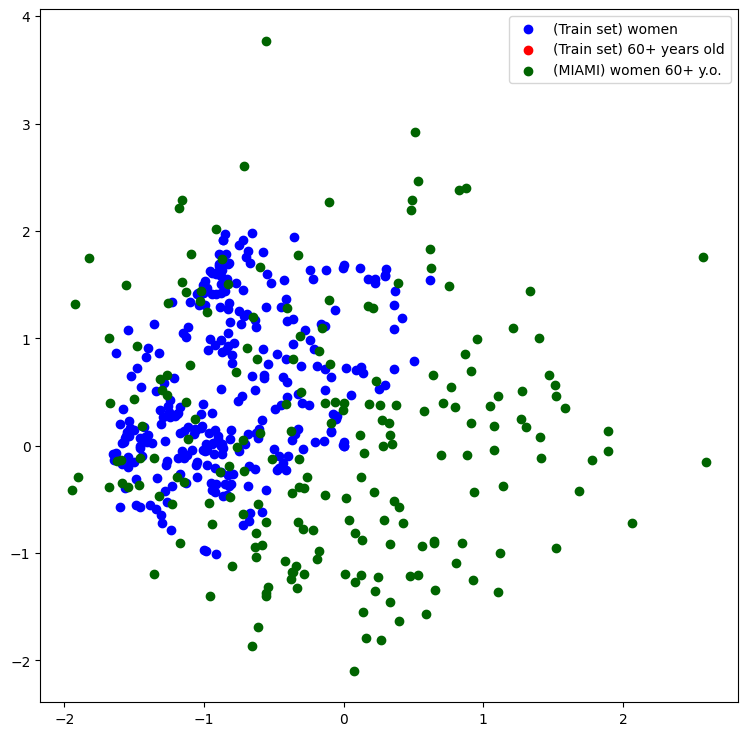

In [18]:
zz = out["zz"]
# z2 = np.vstack([zzz for zzz in zz if len(zzz) >0])
# plt.scatter(z2[:,0], z2[:,1])
# x1,y1 = polygon.exterior.coords.xy
# plt.plot(x1,y1)


# Compare woman, 60+ y.o and people presenting both modalities
zz = np.concatenate(out['zz'])

woman_idx = train['sex'] == 0
age_idx = train['age'] >= 60
bivariate_idx = woman_idx & age_idx

fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(out['Ez.y'][woman_idx,0], out['Ez.y'][woman_idx,1], c='blue', label = '(Train set) women')
ax.scatter(out['Ez.y'][age_idx,0], out['Ez.y'][age_idx,1], c='red', label = '(Train set) 60+ years old')
ax.scatter(zz[:,0], zz[:,1], c='darkgreen', label = '(MIAMI) women 60+ y.o.')
#plt.title('Latent representation of women and 60+ y.o. individuals from the train set and generated by MIAMI')
plt.legend()
plt.show()

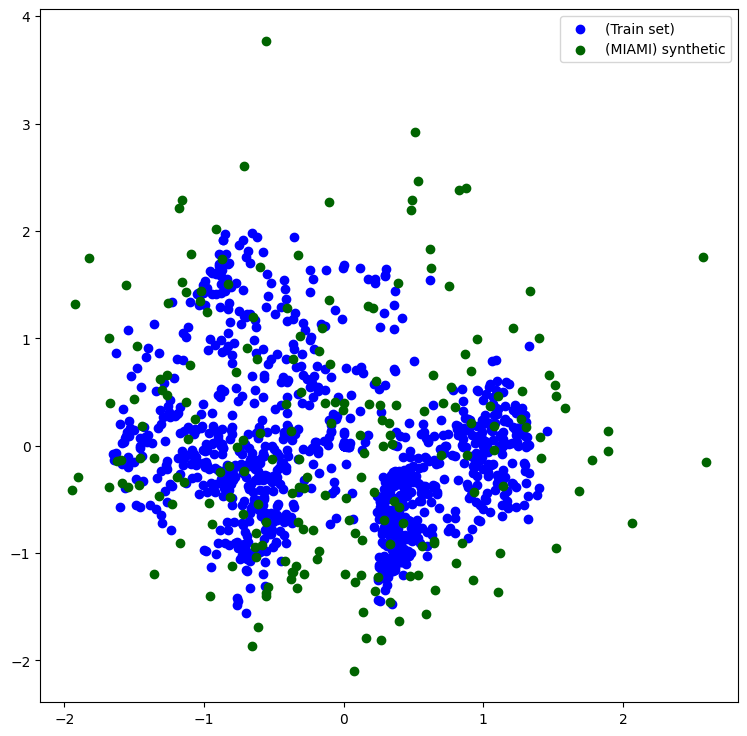

In [19]:
zz = out["zz"]

# z2 = np.vstack([zzz for zzz in zz if len(zzz) >0])
# plt.scatter(z2[:,0], z2[:,1])
# x1,y1 = polygon.exterior.coords.xy
# plt.plot(x1,y1)


# Compare woman, 60+ y.o and people presenting both modalities
zz = np.concatenate(out['zz'])


fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(out['Ez.y'][:,0], out['Ez.y'][:,1], c='blue', label = '(Train set)')
ax.scatter(zz[:,0], zz[:,1], c='darkgreen', label = '(MIAMI) synthetic')
#plt.title('Latent representation of women and 60+ y.o. individuals from the train set and generated by MIAMI')
plt.legend()
plt.show()

In [20]:
print(train.isnull().values.any())


False


Identified outliers: 34


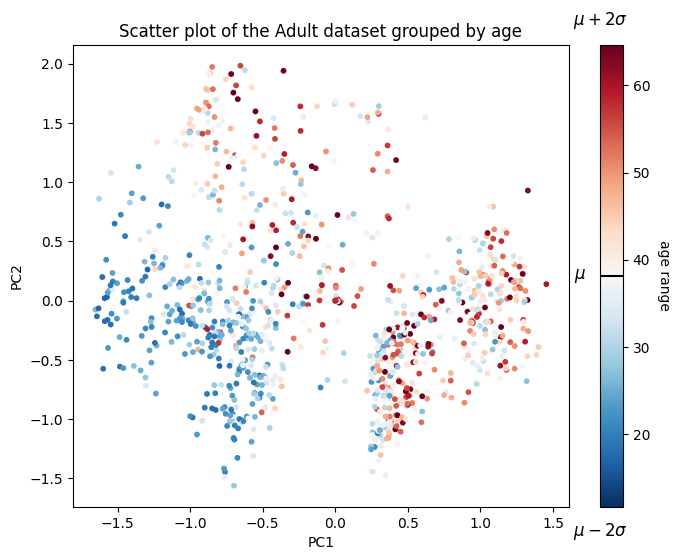

0      2
1      2
2      1
3      2
4      2
      ..
995    2
996    2
997    2
998    2
999    2
Name: workclass, Length: 1000, dtype: object


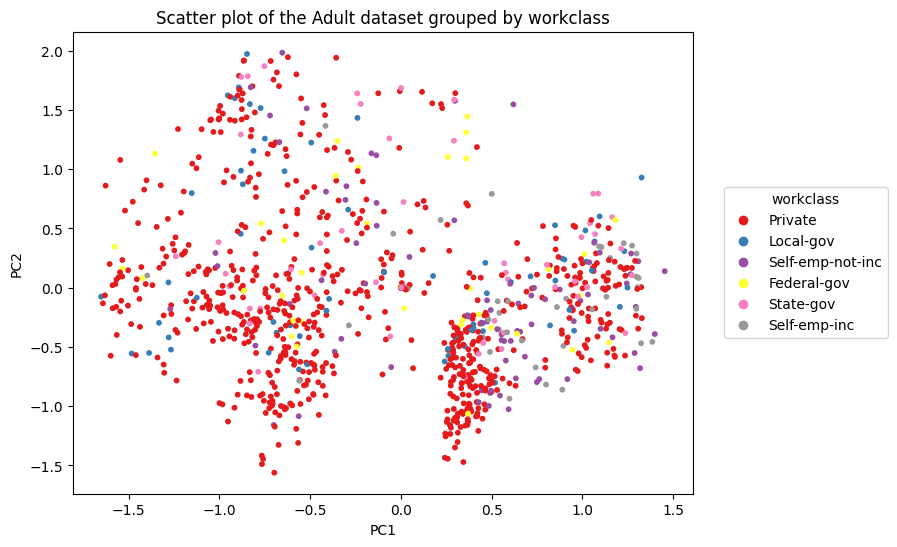

Identified outliers: 44


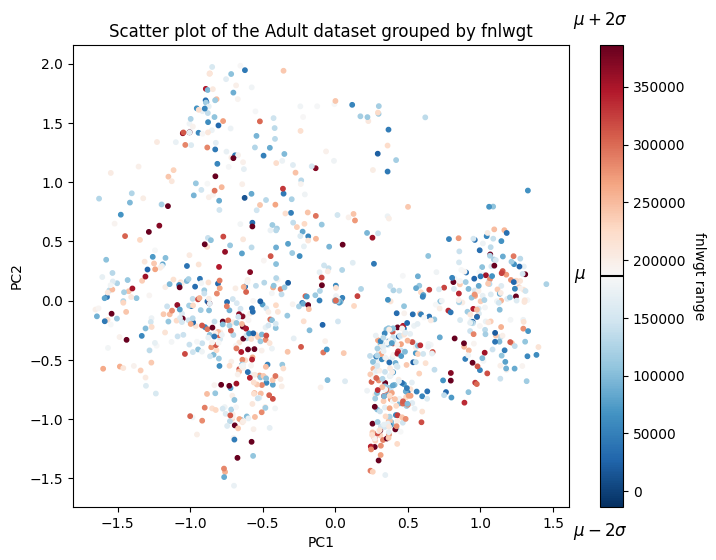

0       1
1      11
2       7
3      15
4       0
       ..
995     5
996    11
997    11
998     9
999    11
Name: education.num, Length: 1000, dtype: int64


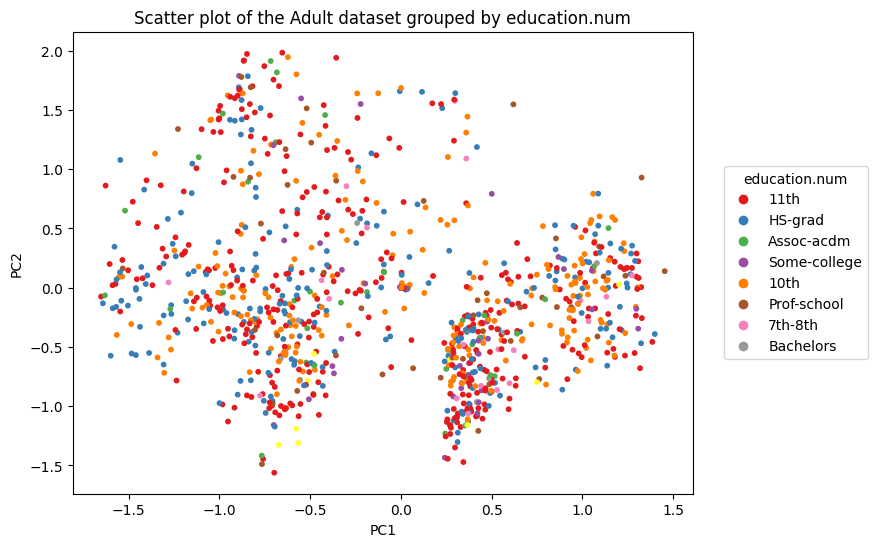

0      4
1      2
2      2
3      2
4      4
      ..
995    6
996    4
997    4
998    2
999    2
Name: marital.status, Length: 1000, dtype: object


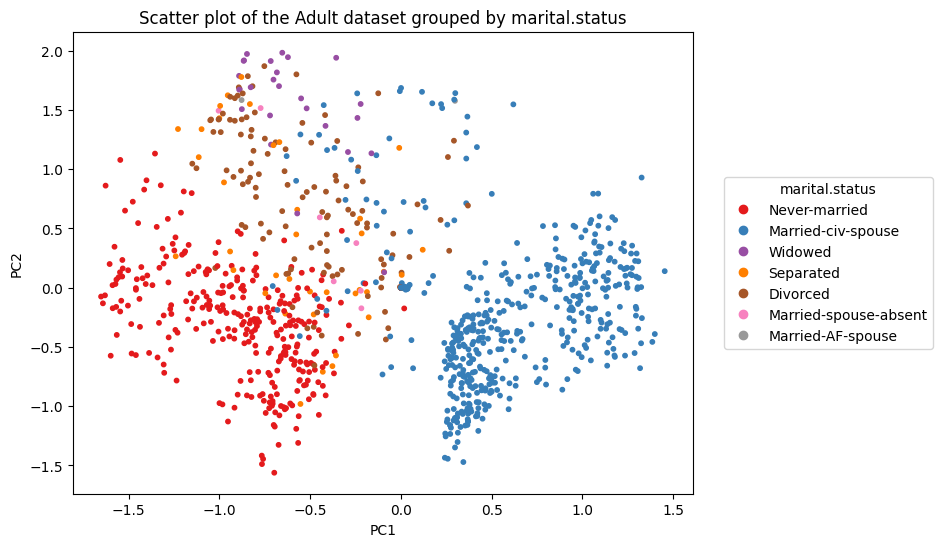

0       6
1       4
2      10
3       6
4       7
       ..
995     6
996     2
997     0
998     2
999     0
Name: occupation, Length: 1000, dtype: object


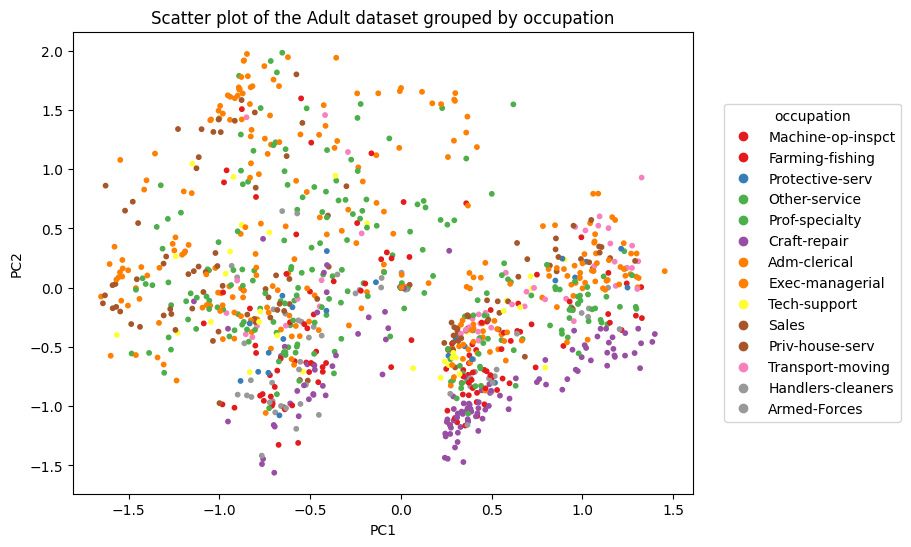

0      3
1      0
2      0
3      0
4      1
      ..
995    4
996    2
997    3
998    0
999    5
Name: relationship, Length: 1000, dtype: object


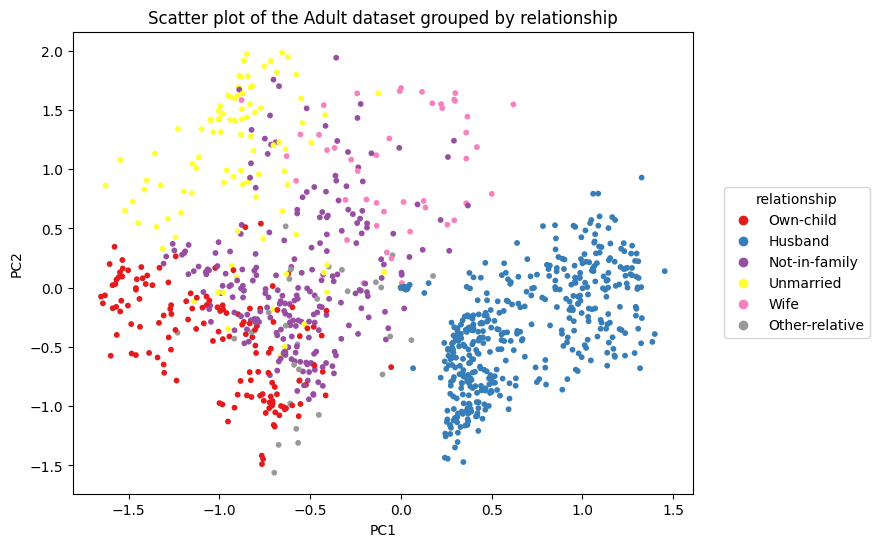

0      2
1      4
2      4
3      2
4      4
      ..
995    4
996    1
997    4
998    4
999    4
Name: race, Length: 1000, dtype: object


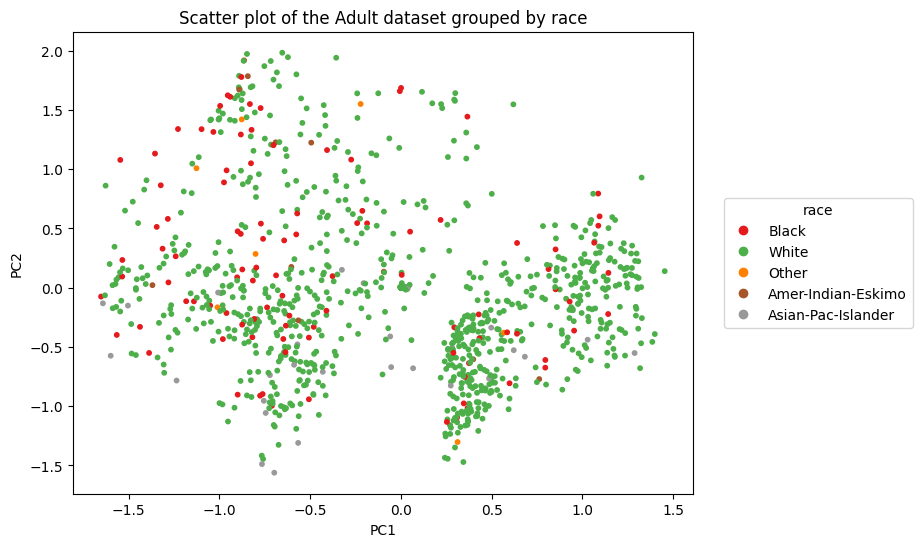

0      1
1      1
2      1
3      1
4      1
      ..
995    0
996    1
997    1
998    1
999    0
Name: sex, Length: 1000, dtype: int64


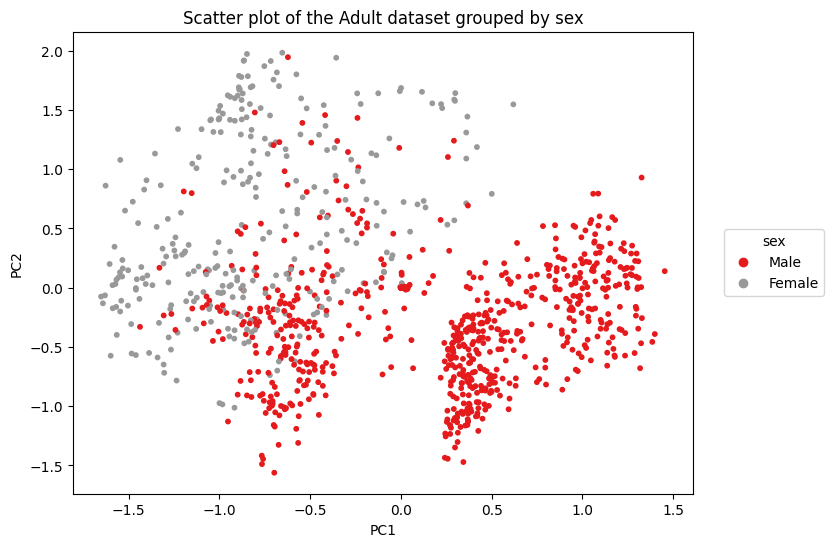

0       0
1       0
2       0
3      36
4       0
       ..
995     3
996     0
997     0
998     0
999     0
Name: capital.gain, Length: 1000, dtype: int64


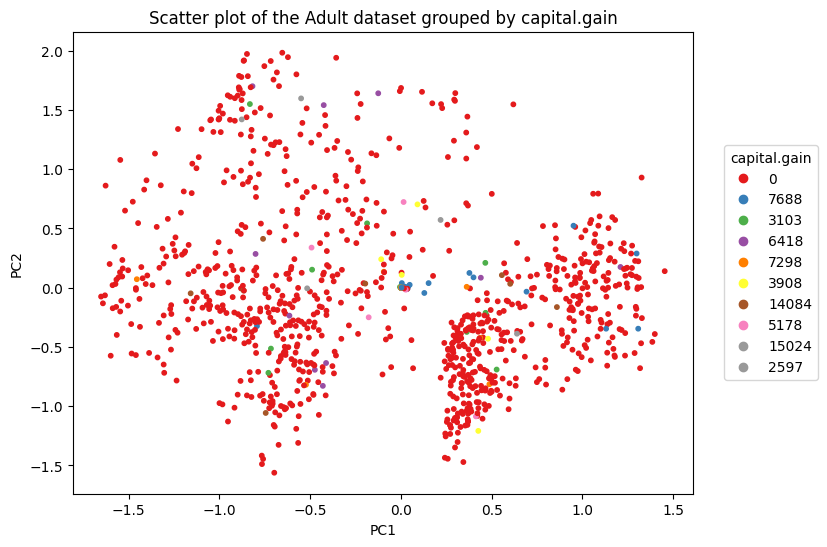

0      0
1      0
2      0
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: capital.loss, Length: 1000, dtype: int64


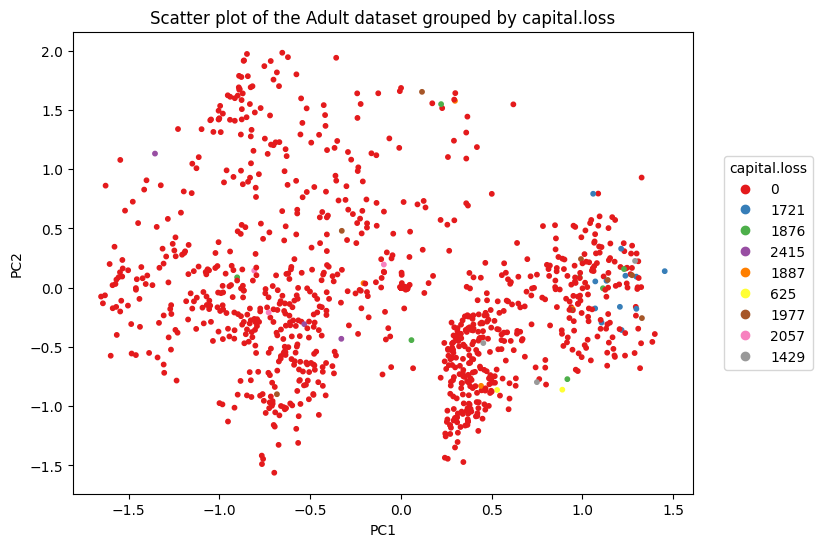

Identified outliers: 63


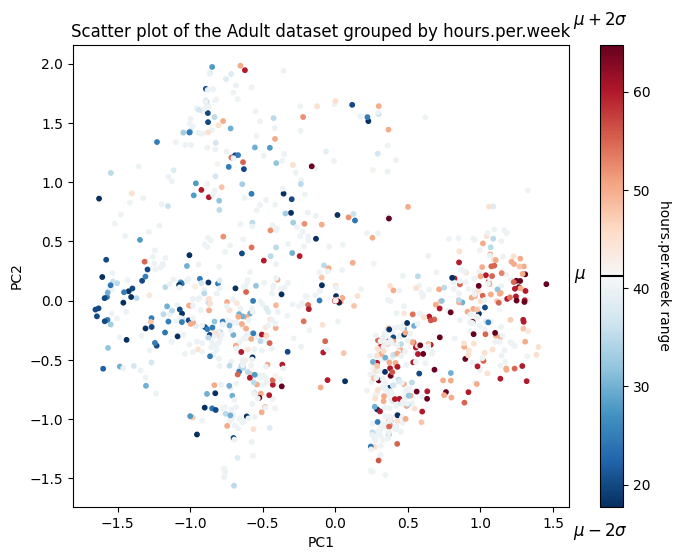

0      26
1      26
2      26
3      26
4      26
       ..
995    26
996     2
997    26
998    26
999    26
Name: native.country, Length: 1000, dtype: object


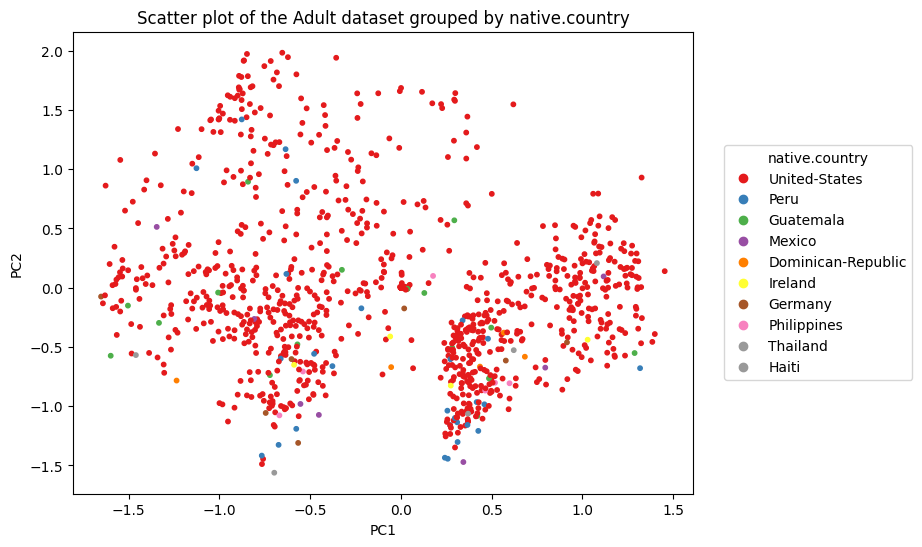

0      0
1      0
2      1
3      1
4      0
      ..
995    0
996    0
997    0
998    1
999    0
Name: income, Length: 1000, dtype: int64


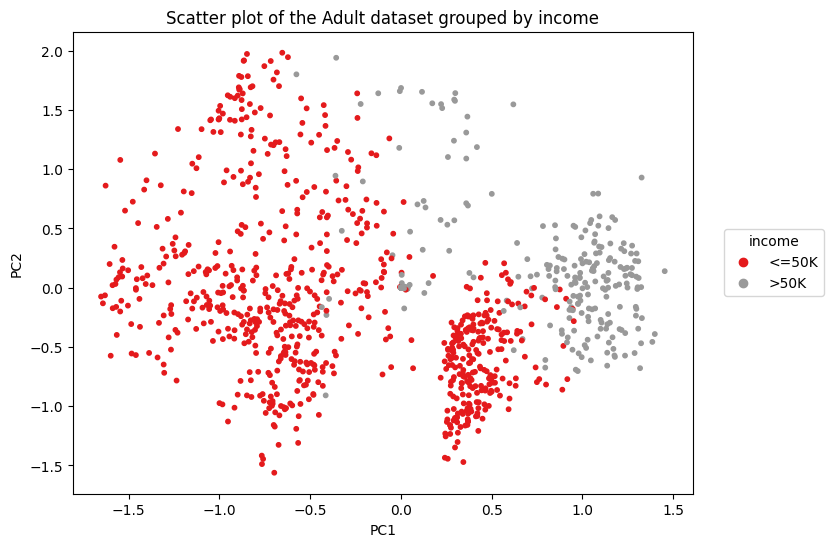

In [21]:
zz = out["zz"]

# z2 = np.vstack([zzz for zzz in zz if len(zzz) >0])
# plt.scatter(z2[:,0], z2[:,1])
# x1,y1 = polygon.exterior.coords.xy
# plt.plot(x1,y1)
k=2 # number of variances from mean

df_scatter = pd.DataFrame()
df_scatter["x"] = out['Ez.y'][:,0]
df_scatter["y"] = out['Ez.y'][:,1]
continuous_position = 0

for col_idx, colname in enumerate(train.columns):
    if var_distrib[col_idx] in ['categorical', 'bernoulli', "ordinal"]: 
    #     feature = "race"
        # le_name_mapping = dict(zip(le_dict[feature].classes_, le_dict[feature].transform(le.classes_)))

        # print(le_name_mapping)
        # labels_real = le_dict[feature].inverse_transform(train_original[feature])
        unique_labels = le_dict[colname].classes_
        le_name_mapping = dict(zip(le_dict[colname].classes_, le_dict[colname].transform(le_dict[colname].classes_)))
#         print(le_name_mapping)
        # Compare woman, 60+ y.o and people presenting both modalities
        zz = np.concatenate(out['zz'])
        df_scatter["c"] = train[colname]
        df_scatter["label"] = train_original[colname]
        print(train[colname])
        # Convert the labels to numeric values
        labels, levels = pd.factorize(df_scatter['label'])

        # Create a scatter plot
        fig, ax = plt.subplots(figsize=(8, 6))
        scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=labels, cmap='Set1', s=10)

        # Add a title and axis labels
        ax.set_title('Scatter plot of the Adult dataset grouped by ' + colname)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')

        # Create a legend
        handles, labels = scatter.legend_elements()
        legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)

        plt.show()
    else:
        # Create a scatter plot
        fig, ax = plt.subplots(figsize=(8, 6))
        minn = scaler.data_min_[continuous_position]
        maxx = scaler.data_max_[continuous_position]
        
        # calculate summary statistics
        data_mean, data_std = np.mean(train_original[colname]), np.std(train_original[colname])
        # identify outliers
        cut_off = data_std * k
        lower, upper = data_mean - cut_off, data_mean + cut_off
        # identify outliers
        outliers = [x for x in train_original[colname] if x < lower or x > upper]
        print('Identified outliers: %d' % len(outliers))
         
        
        scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=train_original[colname], cmap='RdBu_r', s=10, vmin=lower, vmax=upper)

        # Add a title and axis labels
        ax.set_title('Scatter plot of the Adult dataset grouped by ' + colname)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        cb = plt.colorbar(scatter)
        cb.ax.get_yaxis().labelpad = 15
        cb.ax.set_ylabel(colname + " range", rotation=270)

        # add a horizontal line to the colorbar axis
        cb.ax.hlines(data_mean, 0, 1, color="black")
        # Add an annotation at the mean value on the left of the colorbar
        cb.ax.annotate("$\mu$", xy=(cb.ax.get_xlim()[0], data_mean), xytext=(-10, 0),
                       textcoords="offset points", ha="right", va="center",
                       fontsize=12, color="black")
        cb.ax.annotate(r'$\mu + {} \sigma$'.format(k), xy=(0, upper), xytext=(0, 10),
                       textcoords="offset points", ha="center", va="bottom",
                       fontsize=12, color="black")
        cb.ax.annotate(r'$\mu - {} \sigma$'.format(k), xy=(0, lower), xytext=(0, -10),
                       textcoords="offset points", ha="center", va="top",
                       fontsize=12, color="black")
        # Create a legend
#         handles, labels = scatter.legend_elements()
#         legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)
        continuous_position += 1
        plt.show()

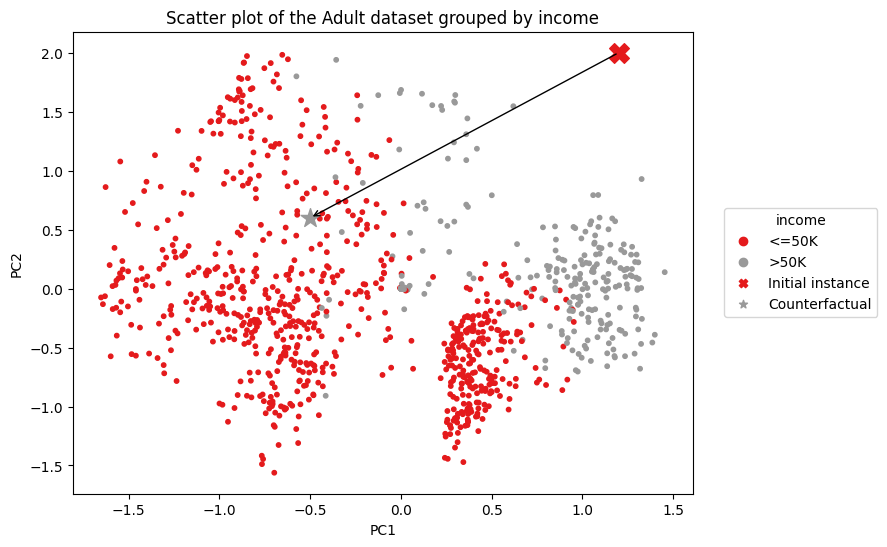

In [22]:
colname = "income"
unique_labels = le_dict[colname].classes_
le_name_mapping = dict(zip(le_dict[colname].classes_, le_dict[colname].transform(le_dict[colname].classes_)))
#         print(le_name_mapping)
# Compare woman, 60+ y.o and people presenting both modalities
zz = np.concatenate(out['zz'])
df_scatter["c"] = train[colname]
df_scatter["label"] = train_original[colname]

# create the second dataframe
df2 = pd.DataFrame({
    'x': [1.2],
    'y': [0],
    'c': [3],
    'label': ['Initial instance']
})

# concatenate the dataframes


# Convert the labels to numeric values
labels, levels = pd.factorize(df_scatter['label'])
levels = list(levels)
# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=labels, cmap='Set1', s=10, vmin=0, vmax=1)

# Add a title and axis labels
ax.set_title('Scatter plot of the Adult dataset grouped by ' + colname)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

x_init, y_init = 1.2, 2

x_end, y_end = -0.5, 0.6

# Get color map
cmap = matplotlib.colormaps.get_cmap('Set1')
colors = [cmap(i) for i in range(cmap.N)]


#Init
scatter_init = ax.scatter(x=x_init, y=y_init, c=0, cmap='Set1', label="Initial instance", marker="X", s=200, vmin=0, vmax=1)


scatter_end = ax.scatter(x=x_end, y=y_end, c=1, cmap='Set1', label="Counterfactual", marker="*", s=200, vmin=0, vmax=1)

# add an arrow between the points
arrow_props = {'arrowstyle': '->', 'lw': 2, 'color': 'black'}
arrow = ax.annotate('', xy=(x_end, y_end), xytext=(x_init, y_init), arrowprops=dict(arrowstyle='->', color='black'))
arrow.set_visible(True)


# Create a legend
handles, labels = scatter.legend_elements()

handles_init, labels_init = scatter_init.legend_elements()
handles_end, labels_end = scatter_end.legend_elements()

handles = handles + handles_init + handles_end
levels = levels + ["Initial instance", "Counterfactual"]
legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)

plt.show()

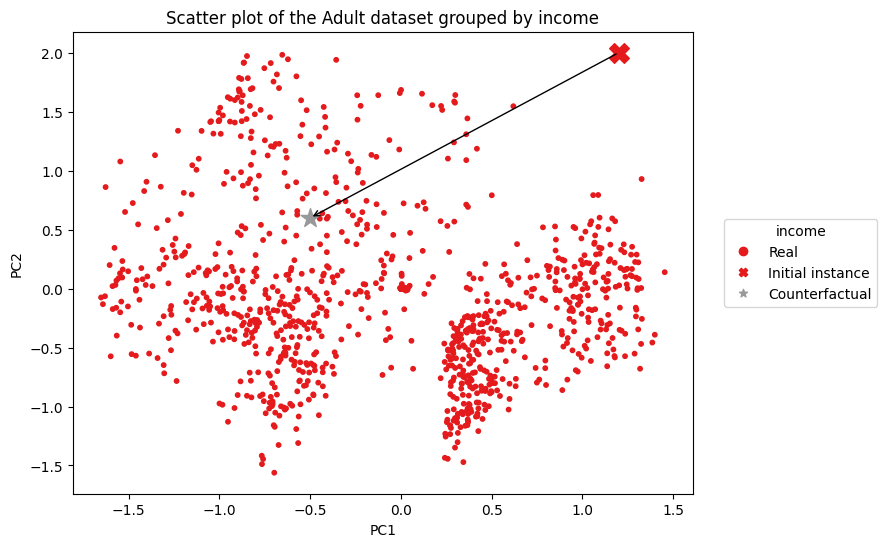

In [23]:
zz = np.concatenate(out['zz'])
df_scatter["c"] = 0
df_scatter["label"] = "Real"


# Convert the labels to numeric values
labels, levels = pd.factorize(df_scatter['label'])
levels = list(levels)
# Create a scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x=df_scatter['x'], y=df_scatter['y'], c=labels, cmap='Set1', s=10, vmin=0, vmax=1)

# Add a title and axis labels
ax.set_title('Scatter plot of the Adult dataset grouped by ' + colname)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

x_init, y_init = 1.2, 2

x_end, y_end = -0.5, 0.6

# Get color map
cmap = matplotlib.colormaps.get_cmap('Set1')
colors = [cmap(i) for i in range(cmap.N)]


#Init
scatter_init = ax.scatter(x=x_init, y=y_init, c=0, cmap='Set1', label="Initial instance", marker="X", s=200, vmin=0, vmax=1)


scatter_end = ax.scatter(x=x_end, y=y_end, c=1, cmap='Set1', label="Counterfactual", marker="*", s=200, vmin=0, vmax=1)

# add an arrow between the points
arrow_props = {'arrowstyle': '->', 'lw': 2, 'color': 'black'}
arrow = ax.annotate('', xy=(x_end, y_end), xytext=(x_init, y_init), arrowprops=dict(arrowstyle='->', color='black'))
arrow.set_visible(True)


# Create a legend
handles, labels = scatter.legend_elements()

handles_init, labels_init = scatter_init.legend_elements()
handles_end, labels_end = scatter_end.legend_elements()

handles = handles + handles_init + handles_end
levels = levels + ["Initial instance", "Counterfactual"]
legend = ax.legend(handles, levels, loc='center left', bbox_to_anchor=(1.05, 0.5), title=colname, borderaxespad=0.)

plt.show()